In [88]:
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Spacingd,
    ToTensord,
    
    SpatialCropd,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandCoarseShuffled,
    CropForegroundd
)

from monai.transforms import MapTransform
from monai.config import KeysCollection
from monai.data.meta_tensor import MetaTensor
from monai.transforms import SpatialCrop
from typing import Dict, Hashable, List

import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
from glob import glob
import os
import shutil
from tqdm import tqdm
from natsort import natsorted


from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism


In [89]:
# class DynamicSlicing(MapTransform):
#     def __init__(self, keys):
#         super().__init__(keys)
#         self.start_slice = -1
#         self.end_slice = -1
#         self.slice_length = 0
#         self.slice_mid = 0

#     def __call__(self, data):
#         d = dict(data)
        
#         print("data : " , data)
        
#         for key in self.keys:
#             mask_path = d[key]
#             mask_img = nib.load(mask_path)
#             mask_data = mask_img.get_fdata()
            
#             print(mask_path)
#             num_slices = mask_data.shape[2]
            

#             for i in range(num_slices):
#                 slice_data = mask_data[:, :, i]
#                 if np.any(slice_data > 0):
#                     if self.start_slice == -1:
#                         self.start_slice = i
#                     self.end_slice = i
                    
#             self.slice_length = self.end_slice-self.start_slice
#             self.slice_mid = self.slice_length // 2

#             d[f"{key}_start"] = self.start_slice
#             d[f"{key}_end"] = self.end_slice
#             d[f"{key}_length"] = self.slice_length
#             d[f"{key}_mid"] = self.slice_mid

#         return d
    

# # sample = [
# #     {
# #     "label": "G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_seg.nii"
# # }
# #     ,
# #     {
# #     "label": "G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_002_seg.nii"
# # }
# # ]

    
# sample =     {
#     "label": "G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_seg.nii"
# }


# transform = DynamicSlicing(keys=["label"])
# result = transform(sample)

# print("Start slice:", result["label_start"])
# print("End slice:", result["label_end"])
# print("slice length:", result["label_length"])
# print("slice mid:", result["label_mid"])


In [90]:
data_path = r"G:\BraTS\MICCAI_BraTS2020_TrainingData"


flair = natsorted(glob(os.path.join(data_path , "*" , "*flair.nii")))[:5]
t1 = natsorted(glob(os.path.join(data_path , "*" , "*t1.nii")))[:5]
t1ce = natsorted(glob(os.path.join(data_path , "*" , "*t1ce.nii")))[:5]
t2 = natsorted(glob(os.path.join(data_path , "*" , "*t2.nii")))[:5]
seg = natsorted(glob(os.path.join(data_path , "*" , "*_seg.nii")))[:5]

In [91]:
seg[0]

'G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_seg.nii'

In [92]:
def find_tumor_slices(mask_path):
    # Load the mask (.nii or .nii.gz)
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata()

    # Get the number of slices
    num_slices = mask_data.shape[2]

    start_slice, end_slice = -1, -1

    # Iterate through slices to find non-zero pixels (tumor regions)
    for i in range(num_slices):
        slice_data = mask_data[:, :, i]
        if np.any(slice_data > 0):  # Check if there is a tumor in this slice
            if start_slice == -1:
                start_slice = i  # First non-zero slice
            end_slice = i  # Keep updating to find the last non-zero slice

    return start_slice, end_slice


In [93]:
data_list = []
for i in range(len(flair)):
    roi_start, roi_end = find_tumor_slices(seg[i])
    
    # Expand the slice range by 3 slices if tumor is detected
    if roi_end >= 3 or roi_start >= 3:
        roi_start -= 3
        roi_end += 3
    
    data_list.append({
        "vol": [flair[i], t1ce[i], t2[i], t1[i]],
        "seg": seg[i],
        "roi_start": [0, 0, roi_start], 
        "roi_end": [160, 160, roi_end]   
    })



len(data_list)

5

In [111]:
data_list

[{'vol': ['G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_flair.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_t1ce.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_t2.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_t1.nii'],
  'seg': 'G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_seg.nii',
  'roi_start': [0, 0, 27],
  'roi_end': [160, 160, 115]},
 {'vol': ['G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_002\\BraTS20_Training_002_flair.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_002\\BraTS20_Training_002_t1ce.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_002\\BraTS20_Training_002_t2.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_002\\BraTS20_Training_002_t1.nii'],
  'seg': 'G:\\BraTS\\MICCAI

In [94]:

# class DynamicSlicing(MapTransform):
#     def __init__(self, keys):
#         super().__init__(keys)

#     def __call__(self, data):
#         d = dict(data)
        
#         for key in self.keys:
#             mask_tensor = d[key]  # this is a MetaTensor or array, not a path
#             if isinstance(mask_tensor, torch.Tensor):
#                 mask_tensor = mask_tensor.numpy()  # convert to numpy if needed
            
#             # Get the number of slices along the 3rd axis (z)
#             num_slices = mask_tensor.shape[-1]  # usually (C, H, W, D) or (H, W, D)

#             start_slice, end_slice = -1, -1

#             for i in range(num_slices):
#                 slice_data = mask_tensor[..., i]  # last axis is the slice
#                 if np.any(slice_data > 0):
#                     if start_slice == -1:
#                         start_slice = i
#                     end_slice = i

#         roi_z_start = max(0, start_slice - 3)
#         roi_z_end = min(mask_tensor.shape[-1], end_slice + 3)

#         d["roi_start"] = [0, 0, roi_z_start]
#         d["roi_end"] = [160, 160, roi_z_end]

#         print("loop ",i," roi_start",roi_start,"\nroi_end : " ,roi_end)

#         return d


# class SpatialCropFromDict(MapTransform):
#     def __init__(
#         self,
#         keys: KeysCollection,
#         roi_start_key: str = "roi_start",
#         roi_end_key: str = "roi_end"
#     ):
#         super().__init__(keys)
#         self.roi_start_key = roi_start_key
#         self.roi_end_key = roi_end_key

#     def __call__(self, data: Dict[Hashable, MetaTensor]) -> Dict[Hashable, MetaTensor]:
#         d = dict(data)
#         roi_start = d[self.roi_start_key]
#         roi_end = d[self.roi_end_key]
#         for key in self.keys:
#             d[key] = SpatialCrop(roi_start=roi_start, roi_end=roi_end)(d[key])
#         return d


In [ ]:
pixdim=(1.2, 1.2,1.0)
spatial_size=[240, 240, 155]
roi_size =[160, 160, 128]

class RelabelTransform(MapTransform):
    def __init__(self, keys, old_label, new_label):
        super().__init__(keys)
        self.old_label = old_label
        self.new_label = new_label

    def __call__(self, data):
        
        d = dict(data)
        
        for key in self.keys:
            d[key][d[key] == self.old_label] = self.new_label
        return d



transforms = [
    LoadImaged(keys=["vol", "seg"]),
    EnsureChannelFirstd(keys=["vol", "seg"]),
    EnsureTyped(keys=["vol", "seg"]),
    # DynamicSlicing(keys=["seg"]),  # this sets d["roi_start"] and d["roi_end"]
    
    Orientationd(keys=["vol", "seg"], axcodes="RAS"),
    Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
    RelabelTransform(keys=["seg"], old_label=4, new_label=3),
    
    # RandSpatialCropd(keys=["vol","seg"], roi_size=roi_size),
    
    # CropForegroundd(keys=["vol", "seg"], source_key="seg"),
    SpatialCropd(keys=["vol","seg"], roi_center=[100,100,79] ,roi_size=roi_size ),

    RandFlipd(keys=["vol", "seg"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["vol", "seg"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["vol", "seg"], prob=0.5, spatial_axis=2),
    
    RandGaussianNoised(keys=["vol"], prob=0.6, mean=0.0, std=0.1),
    
    RandCoarseShuffled(
    keys=["vol"],
    prob=0.7,
    holes=10 ,
    spatial_size=(16, 16, 16)
),
    RandAdjustContrastd(keys=["vol"] ,prob=0.7,gamma=(0.8,1.25)),
    
    NormalizeIntensityd(keys="vol", nonzero=True, channel_wise=True),
    RandScaleIntensityd(keys="vol", factors=0.15, prob=0.7),
    RandShiftIntensityd(keys="vol", offsets=0.15, prob=0.7),
    ToTensord(keys=["vol", "seg"]),
]
# transforms = Compose(
#         [
#             LoadImaged(keys=["vol", "seg"]),
#             EnsureChannelFirstd(keys=["vol", "seg"]),
#             Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
#             Orientationd(keys=["vol", "seg"], axcodes="RAS"),
#             ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
#             CropForegroundd(keys=["vol", "seg"], source_key="vol"),
#             Resized(keys=["vol", "seg"], spatial_size=spatial_size),
#             ToTensord(keys=["vol", "seg"]),

#         ]
#     )


In [96]:
from monai.data import DataLoader, Dataset
from monai.data import DataLoader, pad_list_data_collate
train_ds = Dataset(data=data_list[:5], transform=transforms)
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=pad_list_data_collate  # ← this is key
)

In [97]:
# sample = train_ds[0]
# print(sample["vol"].meta)  # Check if 'pixdim' or 'spacing' key exists


In [98]:
batch = next(iter(train_loader))
batch["vol"].shape , batch["seg"].shape

(torch.Size([2, 4, 160, 160, 128]), torch.Size([2, 1, 160, 160, 128]))

In [99]:
# batch = next(iter(train_loader))
# print(type(batch))
# print(len(batch))  # Number of elements to unpack

# for i, item in enumerate(batch):
#     print(f"Item {i}: type={type(item)}, shape={getattr(item, 'shape', 'no shape')}")


In [100]:
import matplotlib.pyplot as plt

batch_iterator = iter(train_loader)

# Skip first batch
next(batch_iterator)

# Now get 2nd batch
second_batch = next(batch_iterator)

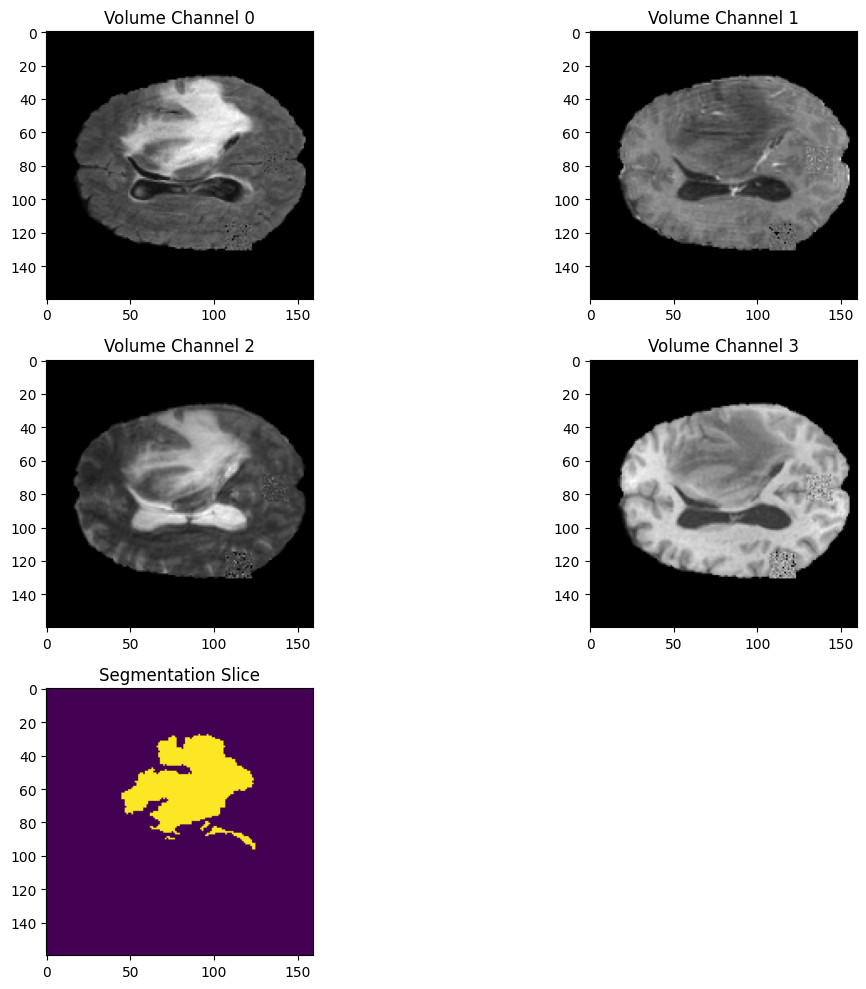

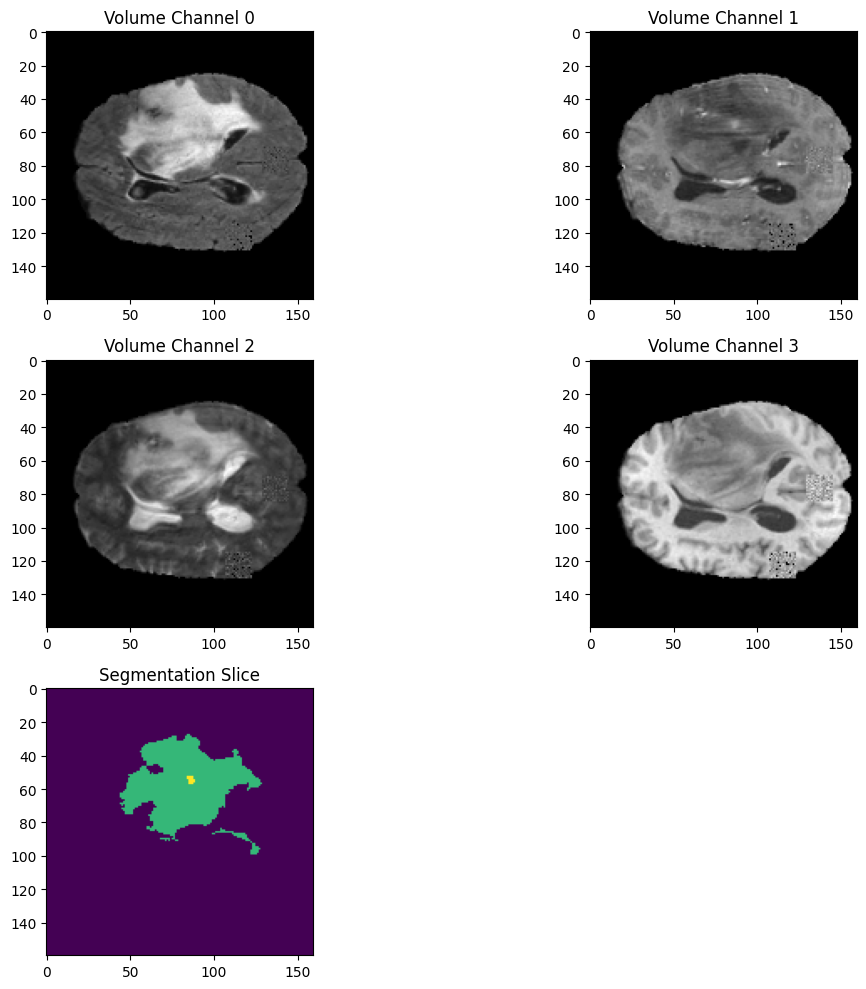

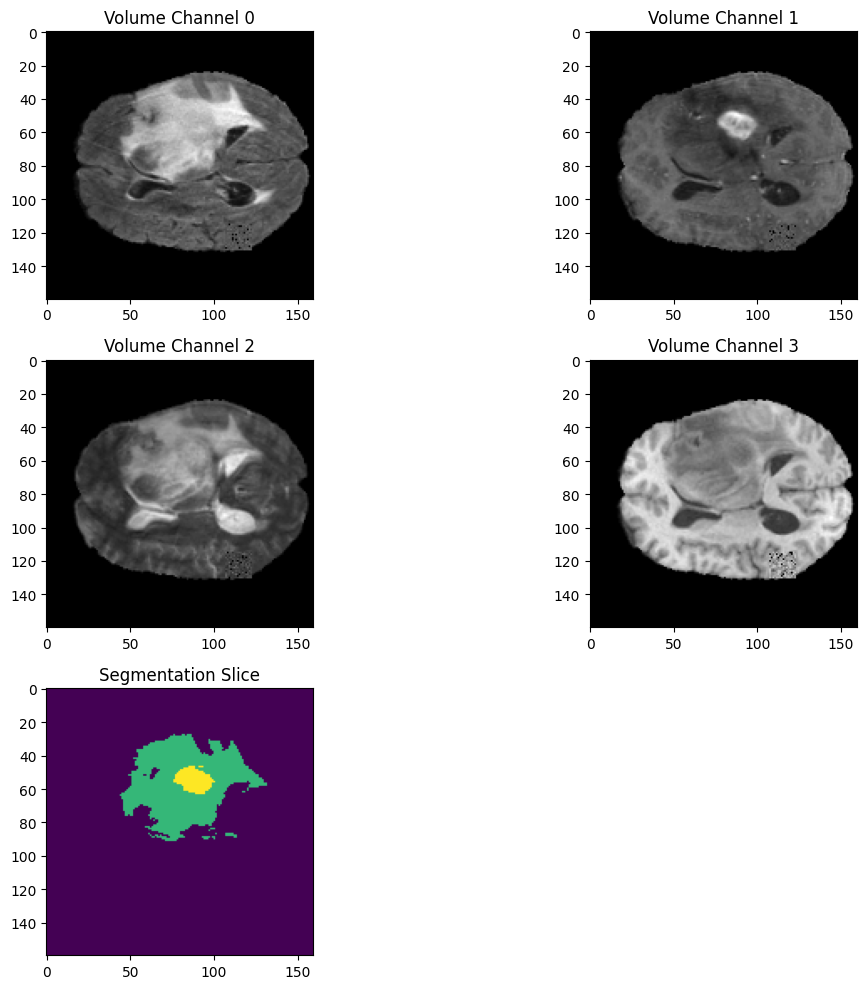

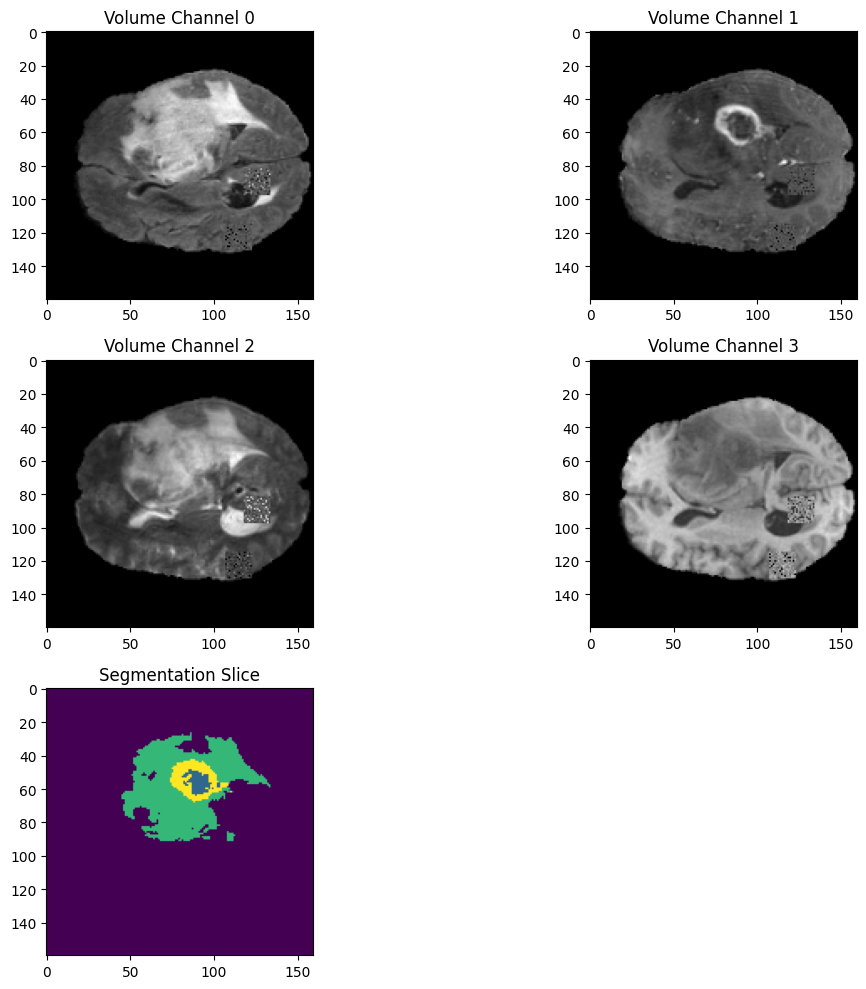

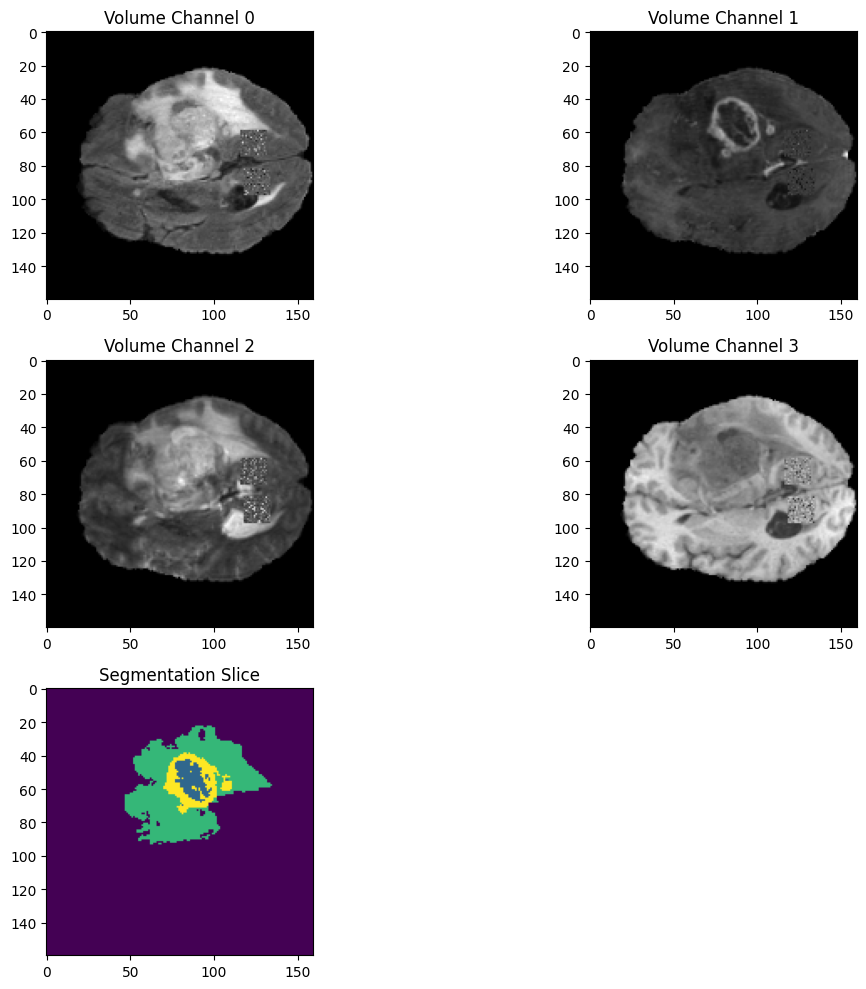

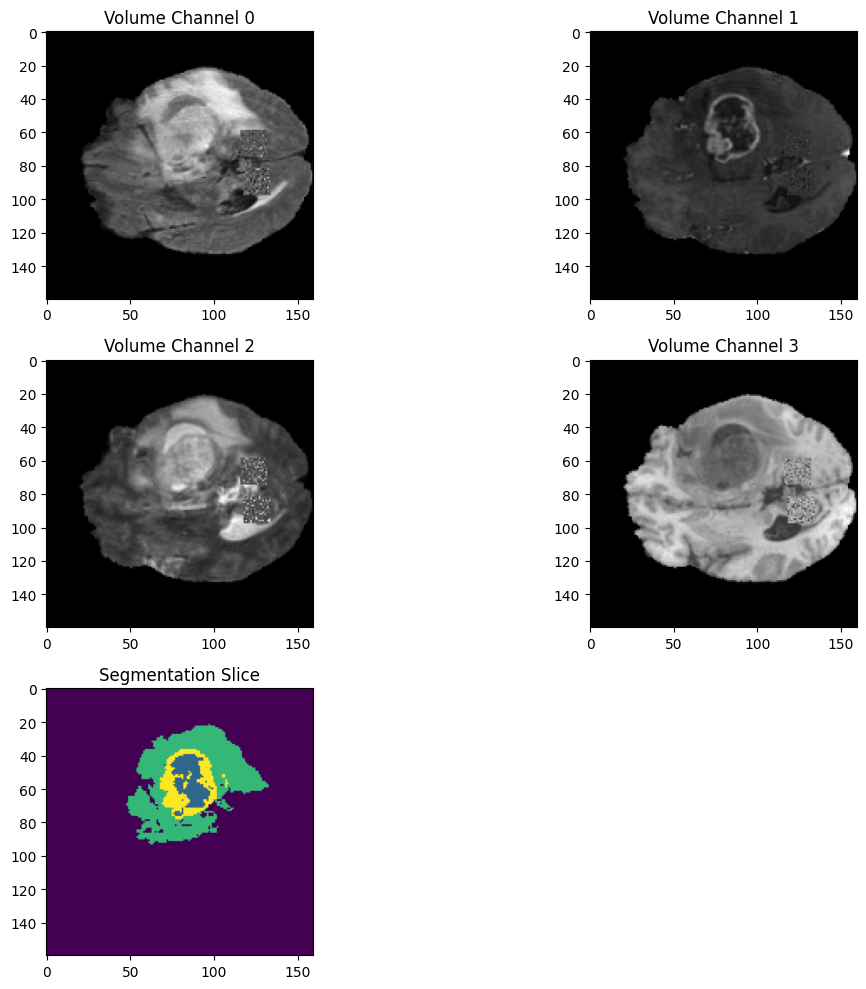

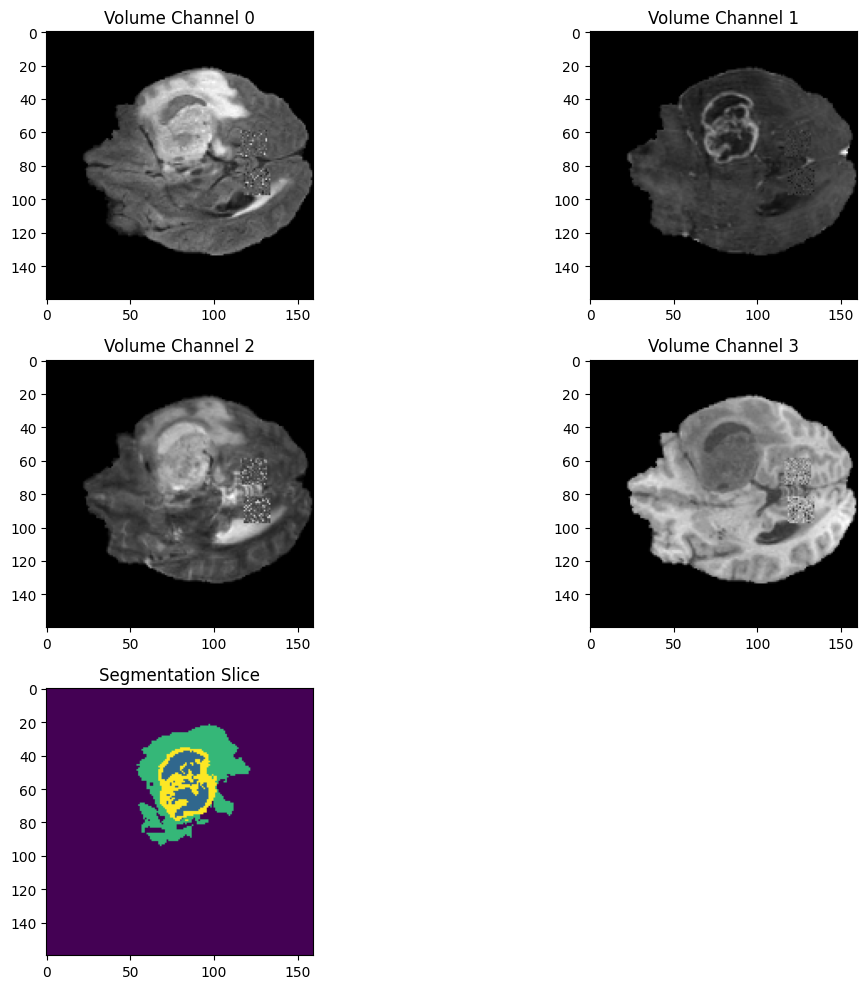

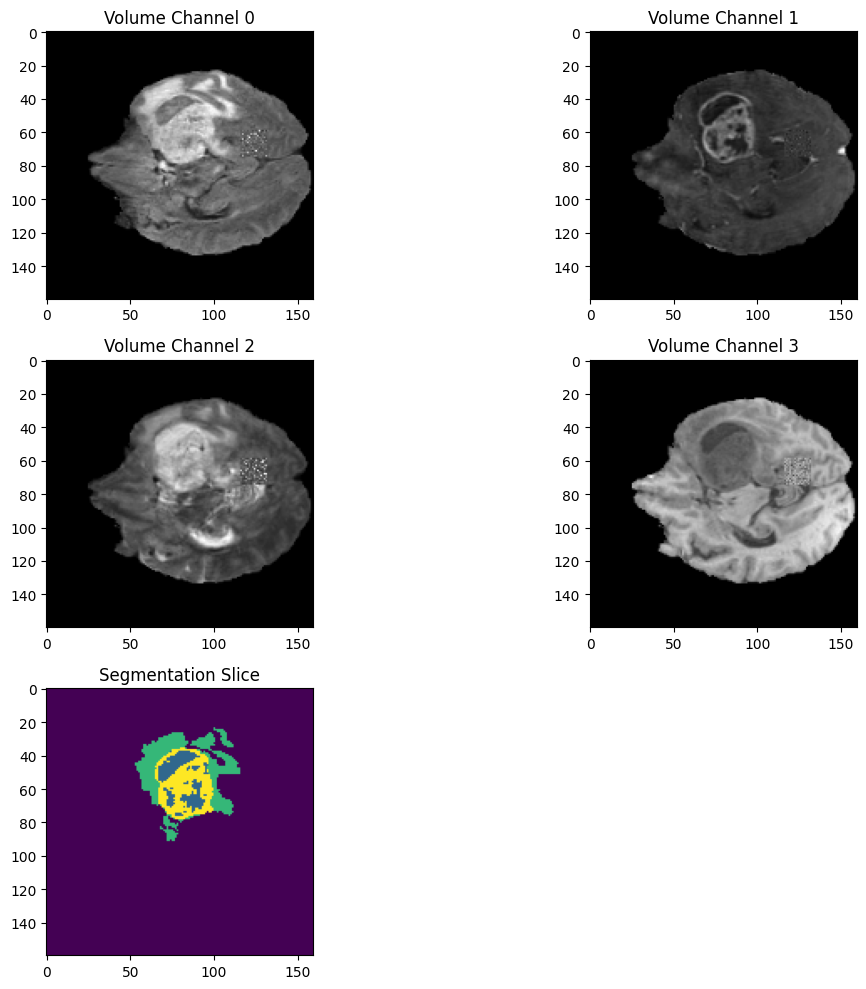

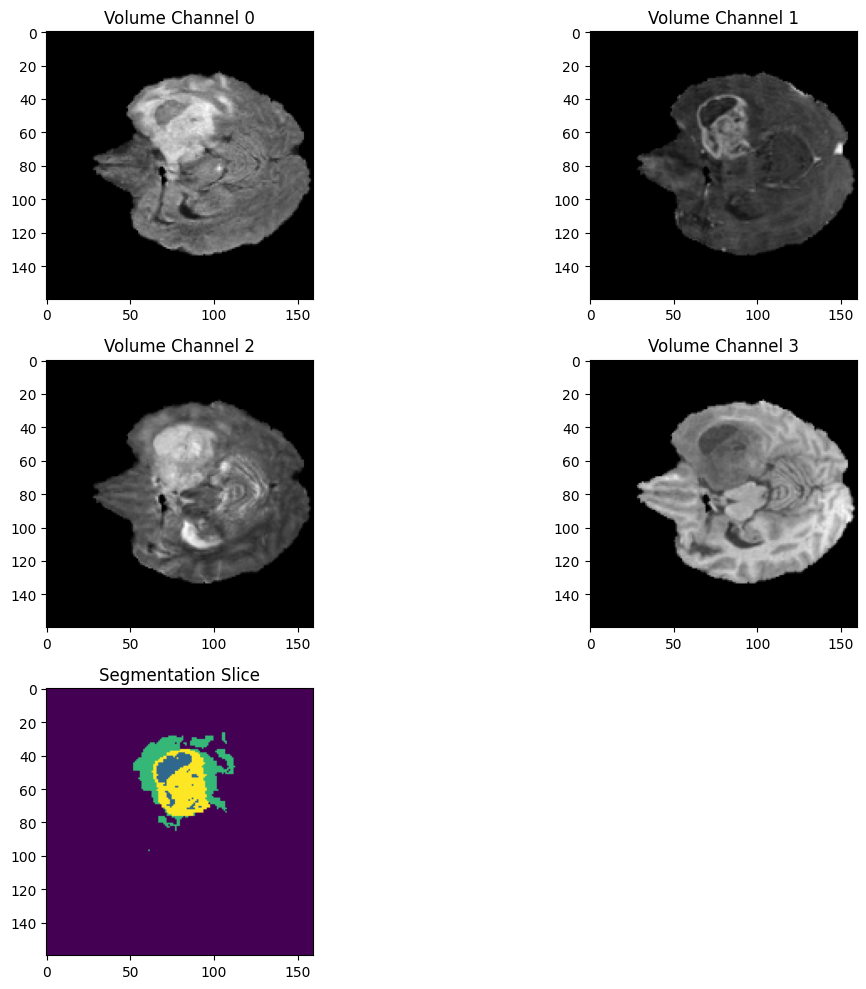

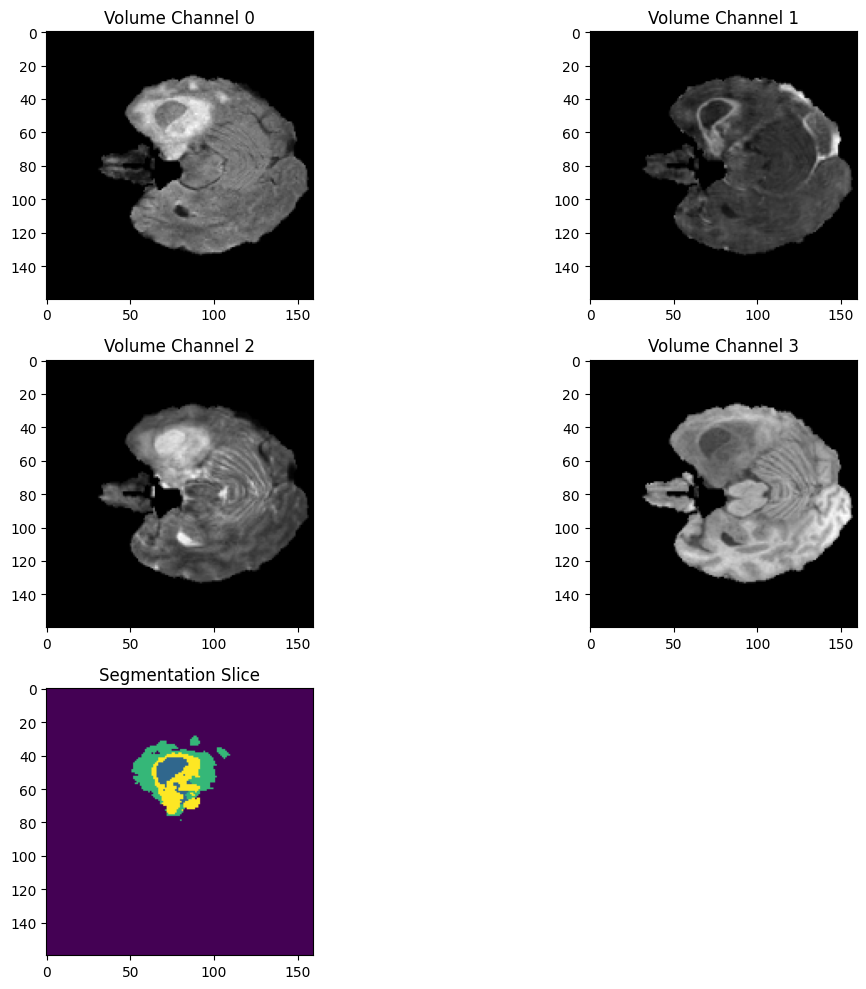

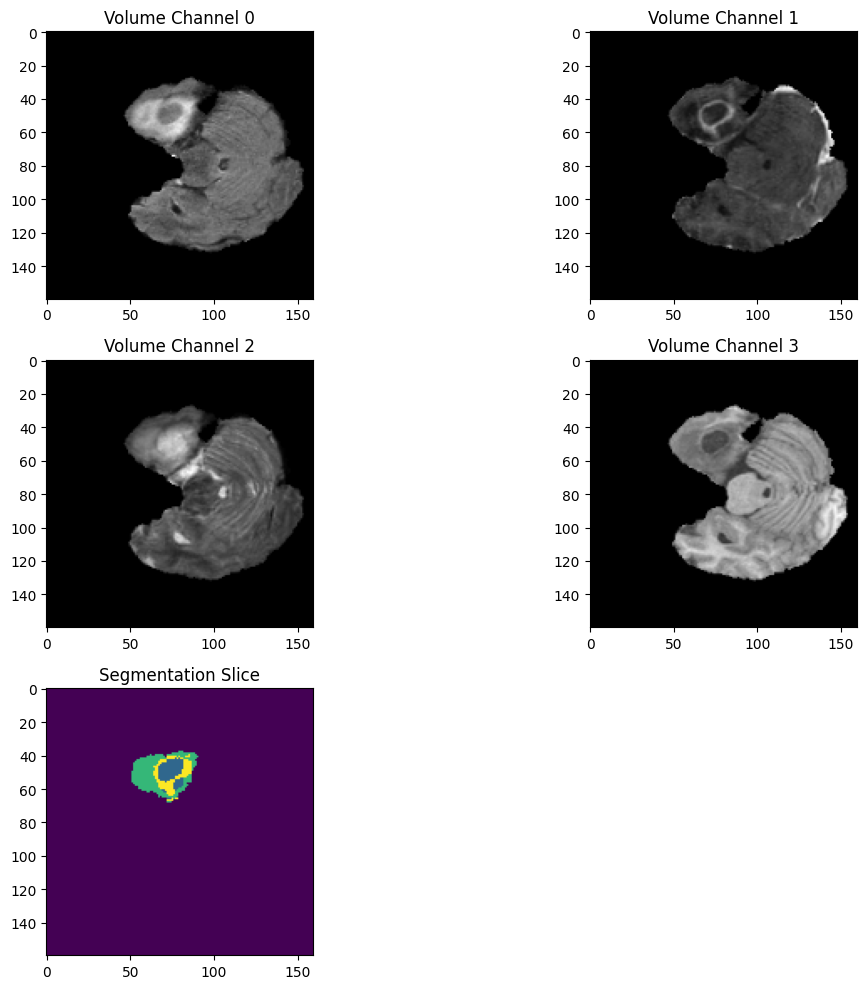

In [101]:

# Access volume and segmentation
vol = second_batch['vol']  # shape: [B, C, H, W, D] or [C, H, W, D]
seg = second_batch['seg']

# Remove batch/channel dim if present (MONAI often adds these)
if vol.ndim == 5:
    vol = vol[0]  # First item in batch
if vol.shape[0] == 1:
    vol = vol[0]  # Remove channel dim

if seg.ndim == 5:
    seg = seg[0]
if seg.shape[0] == 1:
    seg = seg[0]
    

# seg[1].shape
np.unique(seg[:, : , 0])
# seg[:, : , 64]
# len(seg)

# Choose a middle slice along z-axis
# z = 64

for z in range(56,100,4):
    plt.figure(figsize=(12, 10))

    # Volume channel 0
    plt.subplot(3, 2, 1)
    plt.imshow(vol[0, :, :, z], cmap='gray')
    plt.title("Volume Channel 0")
    # plt.axis('off')
    plt.axis('on')

    # Volume channel 1
    plt.subplot(3, 2, 2)
    plt.imshow(vol[1, :, :, z], cmap='gray')
    plt.title("Volume Channel 1")
    # plt.axis('off')
    plt.axis('on')

    # Volume channel 2
    plt.subplot(3, 2, 3)
    plt.imshow(vol[2, :, :, z], cmap='gray')
    plt.title("Volume Channel 2")
    # plt.axis('off')
    plt.axis('on')

    # Volume channel 3
    plt.subplot(3, 2, 4)
    plt.imshow(vol[3, :, :, z], cmap='gray')
    plt.title("Volume Channel 3")
    # plt.axis('off')
    plt.axis('on')

    # Segmentation slice (binary or multi-class)
    plt.subplot(3, 2, 5)
    plt.imshow(seg[:, :, z], cmap='viridis')  # You can use 'tab10' or 'nipy_spectral' for better class distinction
    plt.title("Segmentation Slice")
    plt.axis('on')



    plt.tight_layout()
    plt.show()


In [102]:
in_dir =  r'G:\BraTS\MICCAI_BraTS2020_TestingData'

In [104]:
flair = natsorted(glob(os.path.join(in_dir, '*/*flair.nii')))
t1 = natsorted(glob(os.path.join(in_dir, '*/*t1.nii')))
t1ce = natsorted(glob(os.path.join(in_dir, '*/*t1ce.nii')))
t2 = natsorted(glob(os.path.join(in_dir, '*/*t2.nii')))
mask = natsorted(glob(os.path.join(in_dir, '*/*seg.nii')))
    

In [105]:
len(flair)

15

In [108]:
train_files = [{"vol": [flair,t2,t1ce ,t1], "seg": mask} for flair,t1,t1ce,t2, mask in
                   zip(flair, t1,t1ce,t2,mask)]



In [110]:
train_files

[{'vol': ['G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_flair.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_t2.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_t1ce.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_t1.nii'],
  'seg': 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_seg.nii'},
 {'vol': ['G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_356\\BraTS20_Training_356_flair.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_356\\BraTS20_Training_356_t2.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_356\\BraTS20_Training_356_t1ce.nii',
   'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_356\\BraTS20_Training_356_t1.nii'],
  'seg': 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_356\\BraTS20_Training_356